# Uncapacitated Facility Location Problem

## Load the data

In [2]:
#### Loading the data
import os
import pandas as pd # type: ignore

# Parameters

#### food demand ####
food_per_person = 1.3 / 1000 # Tons per person

#### transportation costs ####
transportation_cost = 3364 / 10.5 # COP per ton per km

#### facility costs ####
### renting a warehouse
warehouse_cost_per_m2 = 24450 / 4 # COP/semana
### How much space is needed per ton of food
space_per_ton = 10.5/7.8 * 1.1 # ton per m2

# path to the data
data_path = 'data'
municipios_filename = 'municipios_procesado.csv'
distance_matrix_filename = 'distance_matrix_final.csv'
# load the data
population = pd.read_csv(os.path.join(data_path, municipios_filename),
                         usecols=['departamento', 'municipio', 'c_digo_dane_del_departamento', 'dpmp', '2024', 'lat', 'lon'])
distance_matrix = pd.read_csv(os.path.join(data_path, distance_matrix_filename),
                              index_col='dpmp')

# calculate the population per department = sum of the population of the municipalities in the department placed for each municipality in the department
population_per_department = population.groupby('c_digo_dane_del_departamento').sum()
population['population_per_department'] = population['c_digo_dane_del_departamento'].map(population_per_department['2024'])

<Axes: >

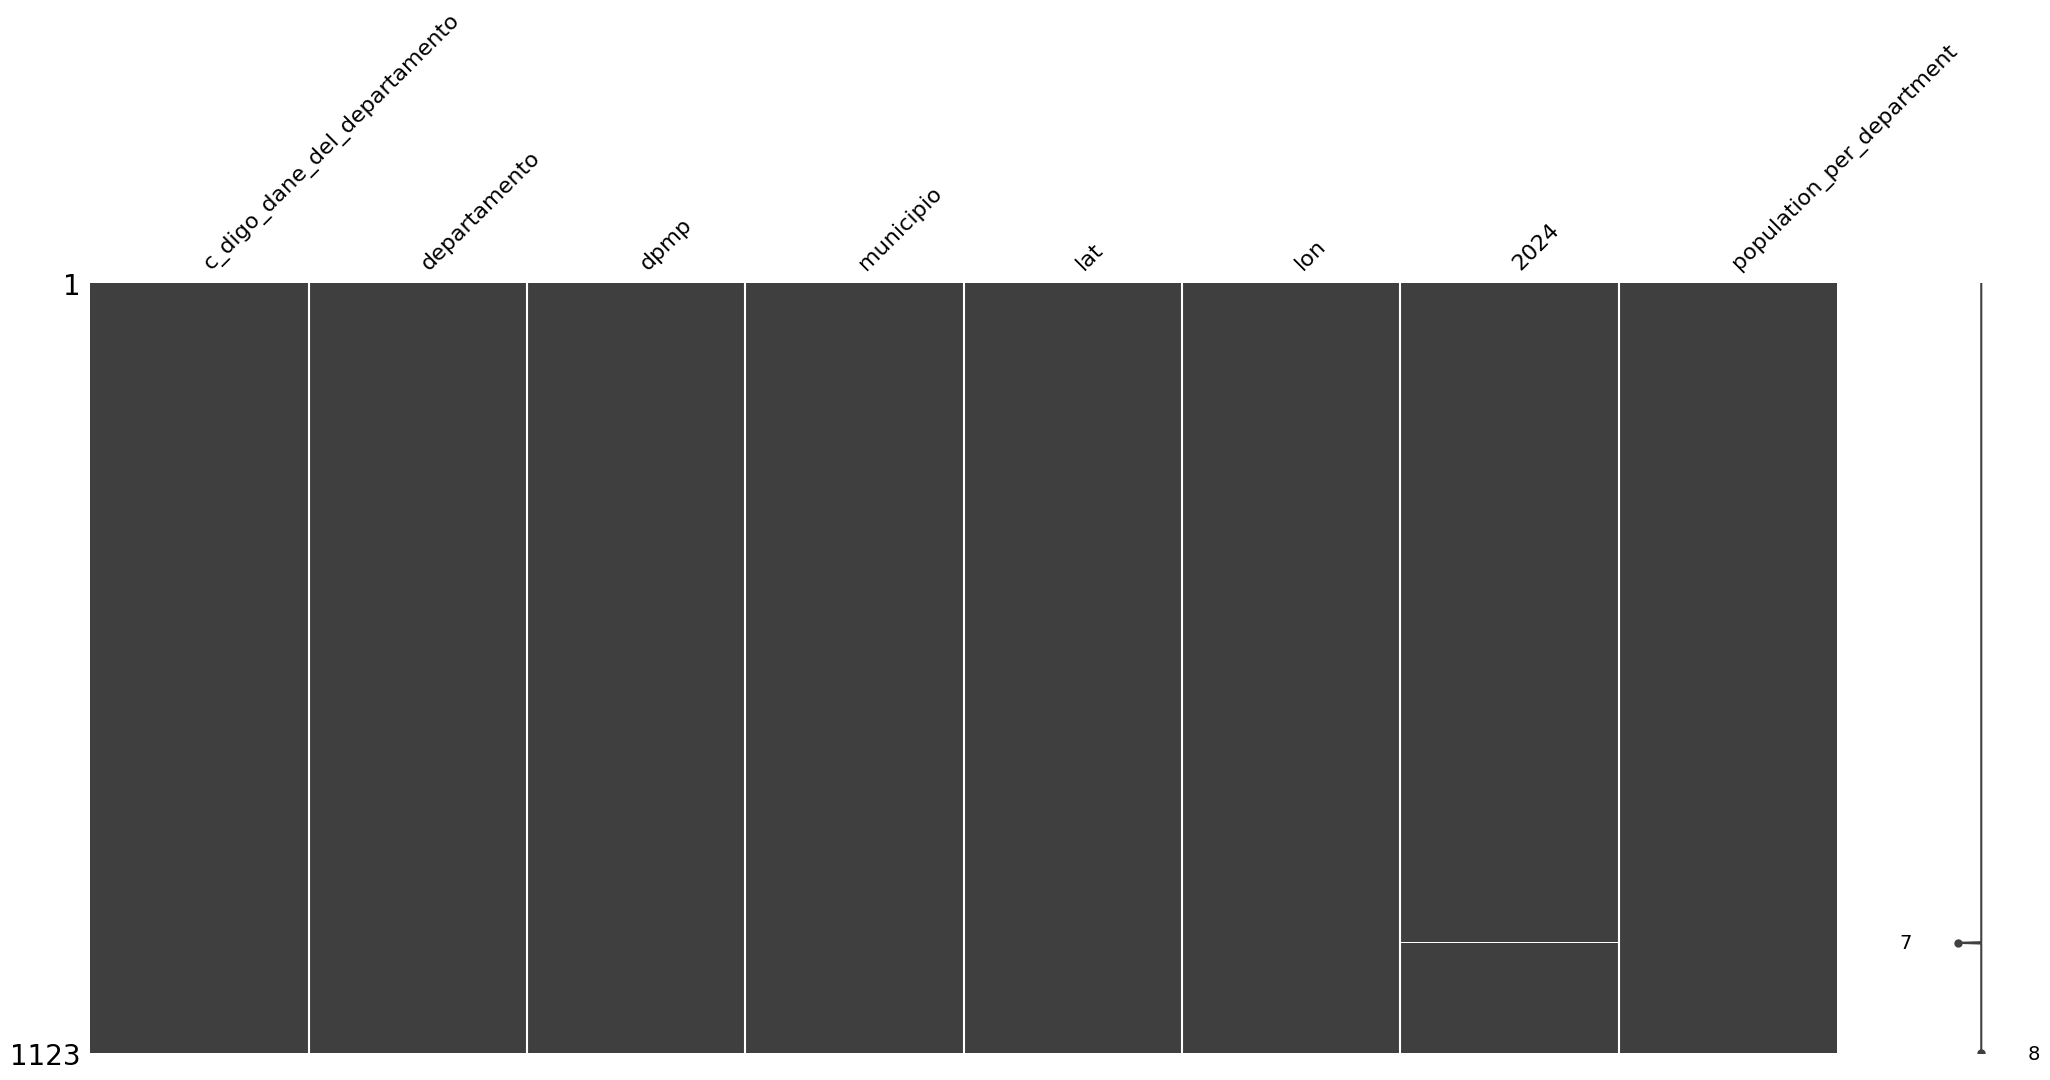

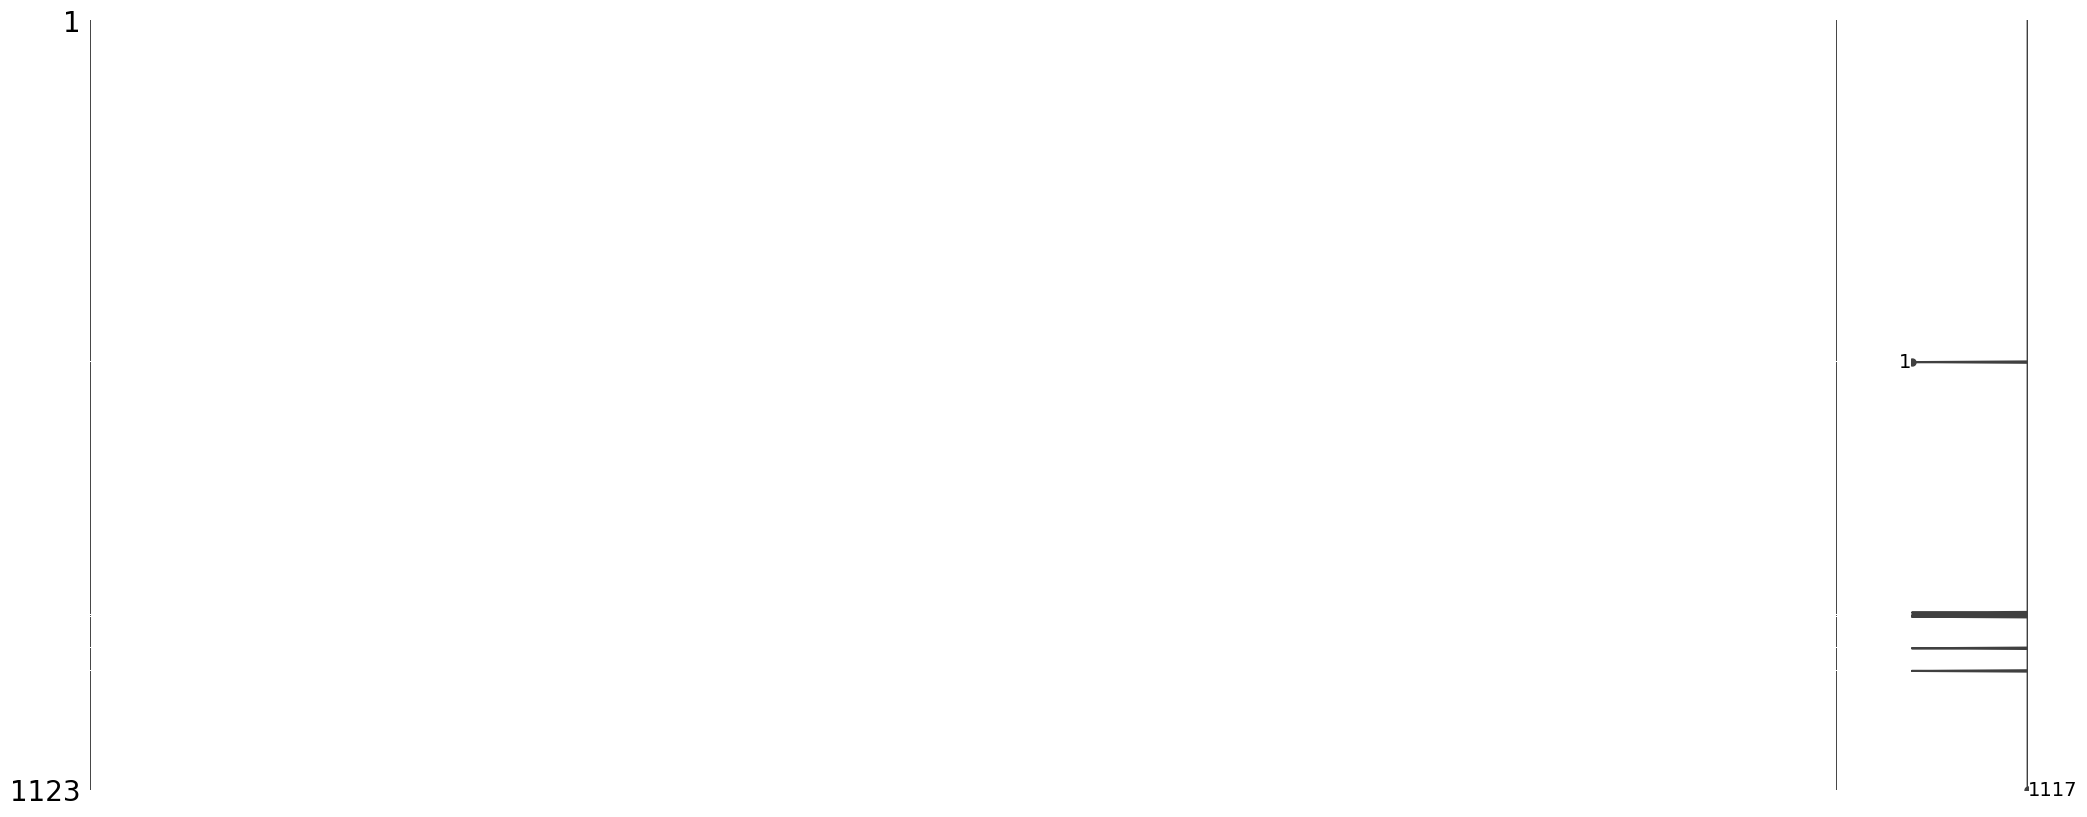

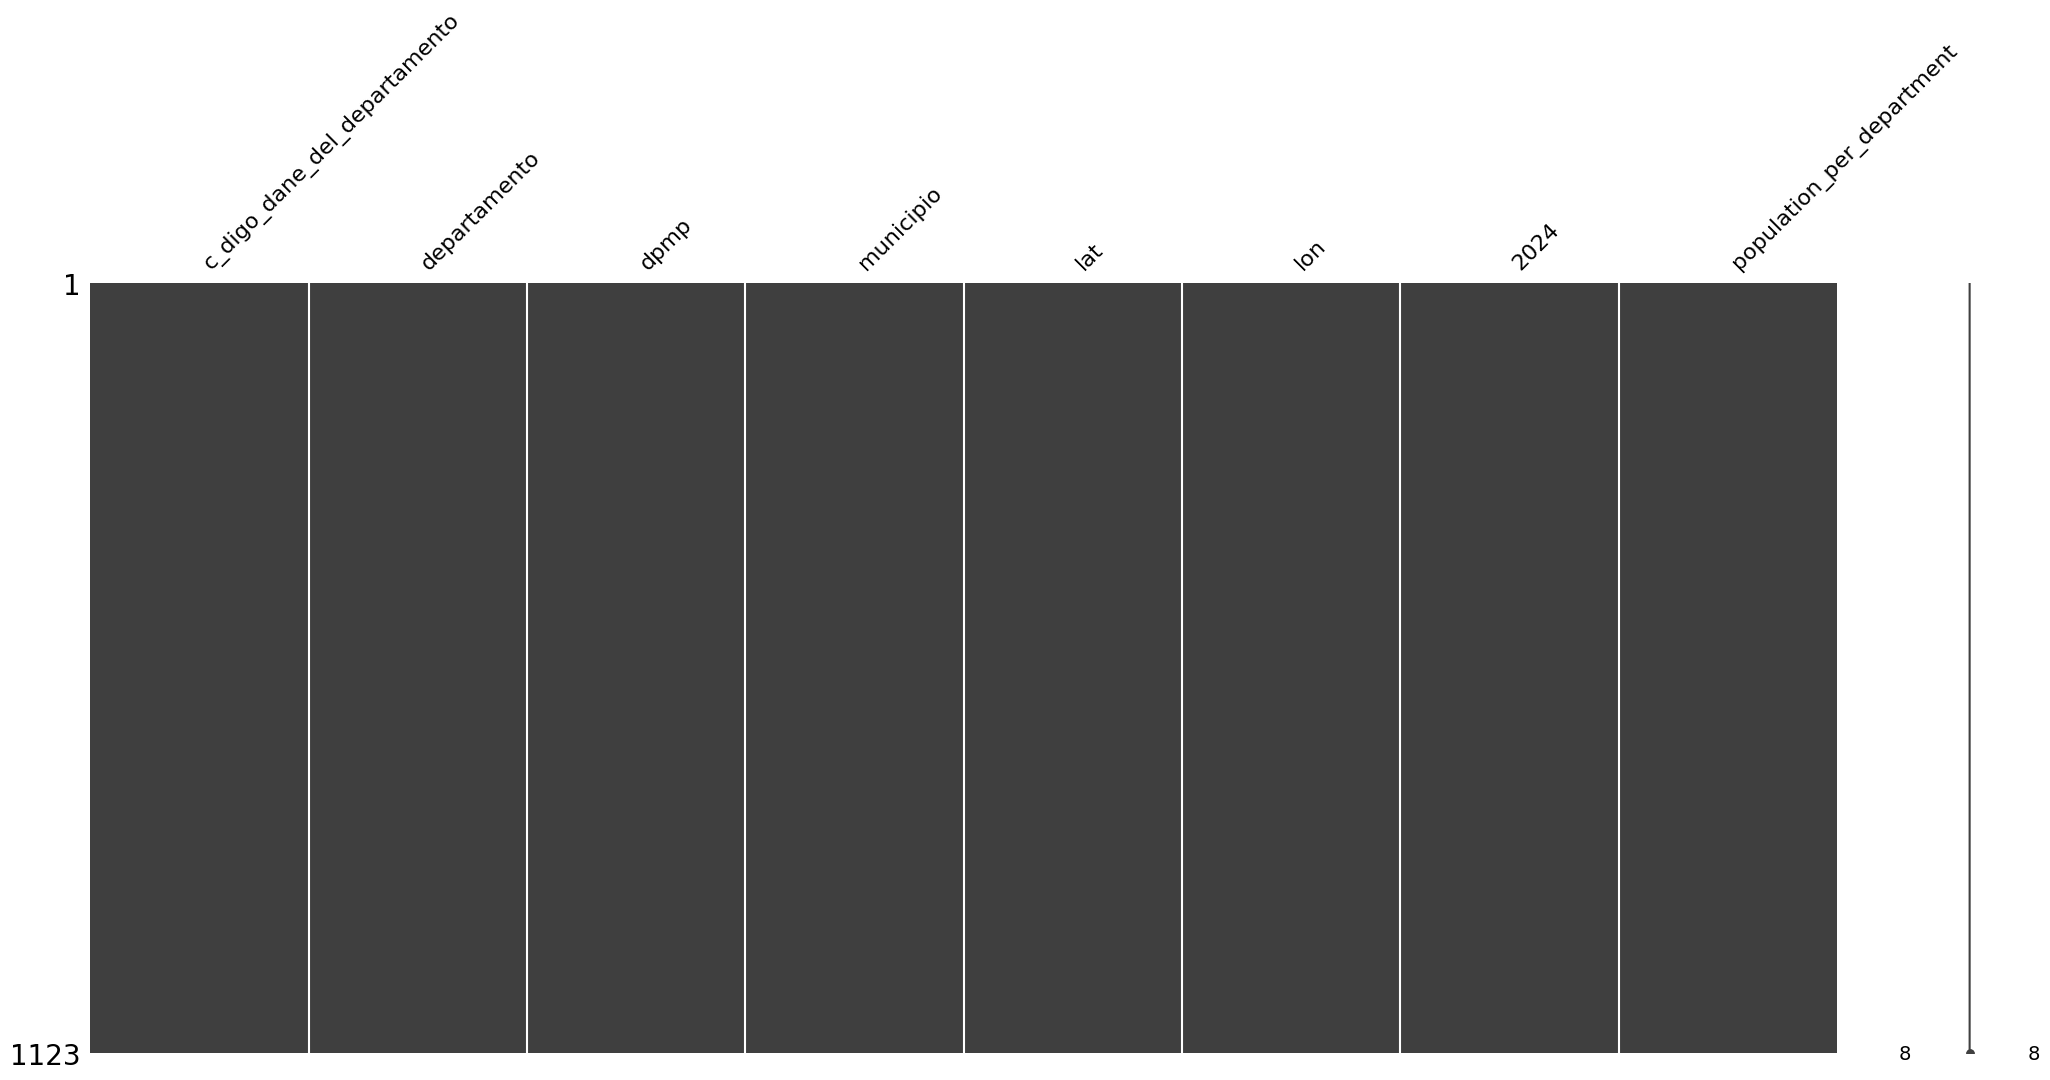

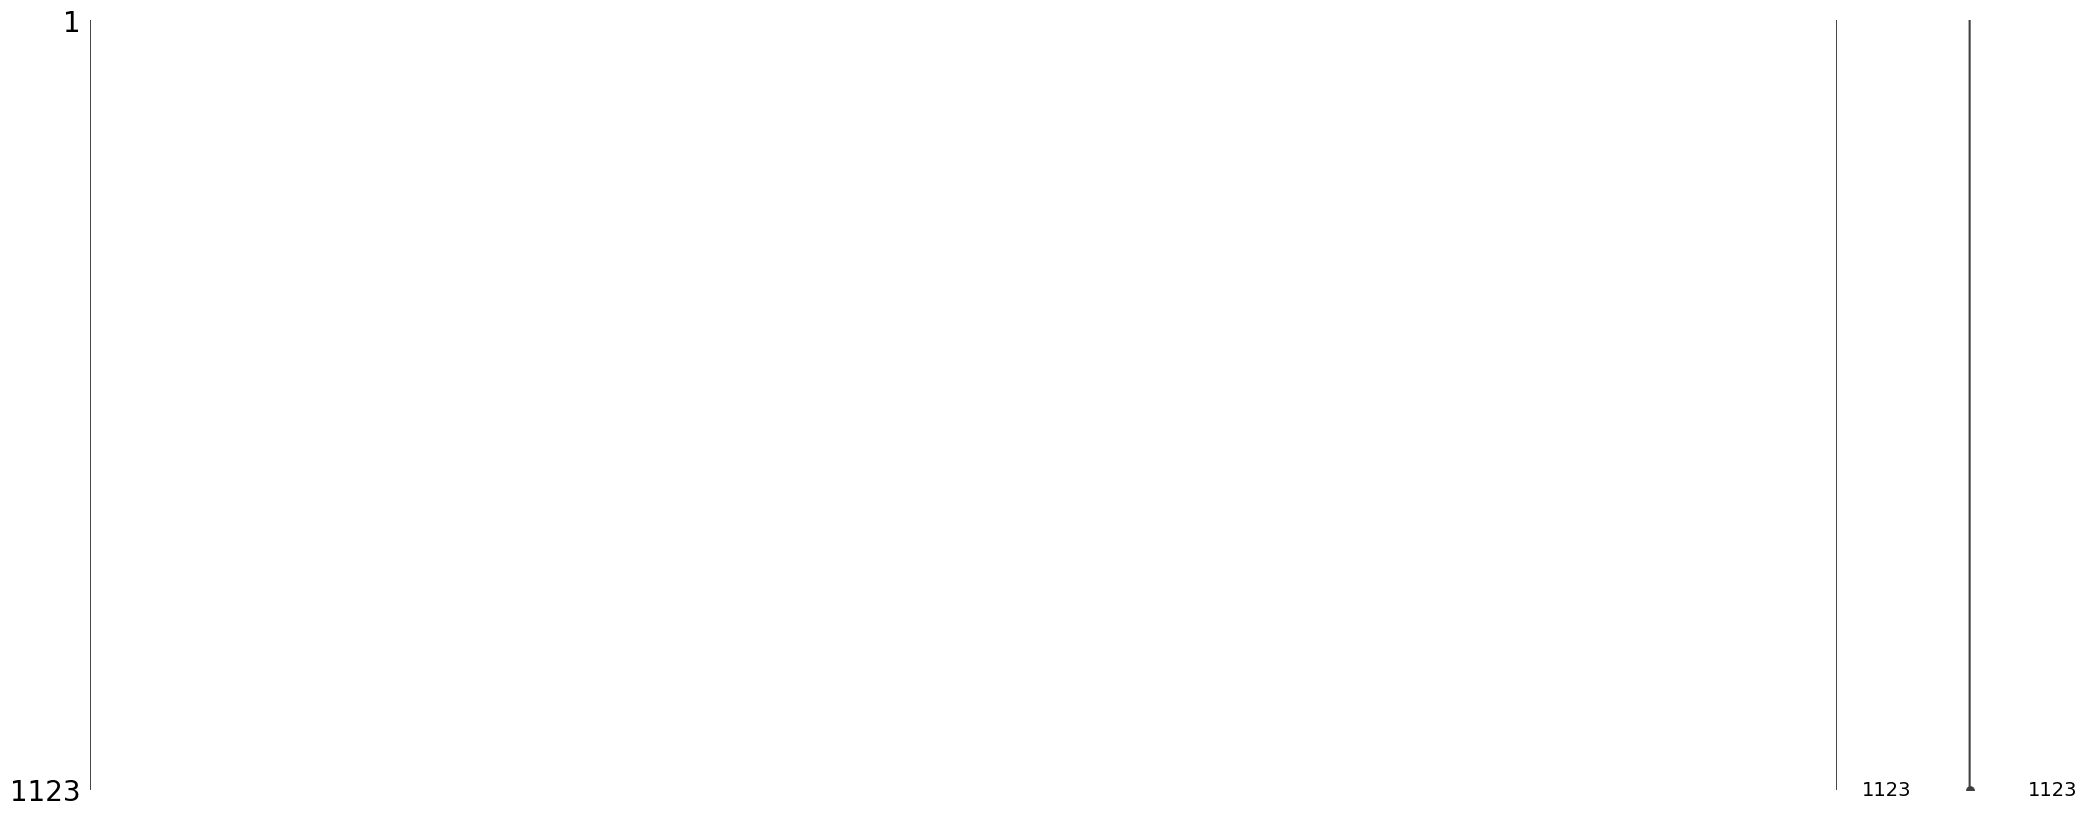

In [3]:
# Check for missing values
import missingno as msno # type: ignore
msno.matrix(population)
msno.matrix(distance_matrix)
# for population, fill all nan values with 0
population.fillna(0, inplace=True)
# for distance matrix, fill all nan values with the maximum value * 100
distance_matrix.fillna(distance_matrix.max().max() * 100, inplace=True)
msno.matrix(population)
msno.matrix(distance_matrix)


## Load the Model

In [4]:
import sys
sys.path.append("..")
from lp.uflp import UFLP

# h_i: demand of food in municipality i
h = population['2024'] * food_per_person
# c_ij: cost of transporting food from municipality i to j
c = distance_matrix * transportation_cost
# f_i: cost of building a warehouse in municipality i warehouse_cost_per_m2 * space_per_ton * department_demand
f = warehouse_cost_per_m2 * space_per_ton * population['population_per_department'] * food_per_person

# Turn the data to lists
h = h.tolist()
c = c.values.tolist()
f = f.tolist()
uflp = UFLP(h, c, f)
uflp.load_to_pulp()


## Solve the problem

In [5]:
#### Solving the problem
uflp.solve_by_pulp()

In [6]:
#### Save the results
solution = uflp.get_solution_by_pulp()
x = solution['x']
y = solution['y']

# X to dataframe
x_df = pd.DataFrame(x, index=[0]).transpose().rename(columns={0: 'x'})
# Y to dataframe
max_index_0 = max(key[0] for key in y.keys())
max_index_1 = max(key[1] for key in y.keys())
y_df = pd.DataFrame(index=range(max_index_0 + 1), columns=range(max_index_1 + 1))
for key, value in y.items():
    y_df.at[key[0], key[1]] = value

# change index and column values to the dpmp of population
x_df.index = population['dpmp'] # type: ignore
y_df.index = population['dpmp'] # type: ignore
y_df.columns = population['dpmp']

solution_combined = pd.concat([x_df, y_df], axis=1)
solution_combined.to_csv('_pilot-solution.csv')


## Display the data

In [15]:
#### Plotting the solution
# The data for the position of the municipalities is in population dataframe
# which municipalities are meant to have a warehouse are the ones with x = 1
# Finally, the value of y_ij is the percentage of food that is going from i to j
# The map must be scoped to the country of Colombia
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd

fig = go.Figure(
    data=go.Scattergeo(
        lon=population['lon'],
        lat=population['lat'],
        text=population['departamento'] + ', ' + population['municipio'],
        mode='markers',
        marker_color=x_df['x'].map({0: 'blue', 1: 'red'}),
    )
)
# Add the lines using the y_ij values
# for i in range(len(y_df)):
#     for j in range(len(y_df.columns)):
#         if float(y_df.iloc[i, j]) > 0:
#             fig.add_trace(
#                 go.Scattergeo(
#                     lon=[population['lon'][i], population['lon'][j]],
#                     lat=[population['lat'][i], population['lat'][j]],
#                     mode='lines',
#                     line=dict(
#                         width= float(y_df.iloc[i, j]) * 10,
#                         color='red'
#                     )
#                 )
#             )
fig.update_geos(
    resolution=110,
    showcountries=True,
    countrycolor="Black",
    showsubunits=True,
    subunitcolor="Blue"
)
# fig.update_layout(
#     title_text='Warehouse locations',
#     geo=dict(
#         showframe=False,
#         showcoastlines=True,
#         projection_type='equirectangular'
#     )
# )
fig.show()


## END